# Contractions optimized via treewidth

Below is some code needed for defining the circuits and running the benchmarks. For the results go directly to section [Results](#report)


In [1]:
] add https://github.com/Qaintum/Qaintessent.jl#view-matrix-gate

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Updating git-repo `https://github.com/Qaintum/Qaintessent.jl`
  Updating git-repo `https://github.com/Qaintum/Qaintessent.jl`
 Resolving package versions...
  Updating `~/projects/Qaintensor.jl/Project.toml`
 [no changes]
  Updating `~/projects/Qaintensor.jl/Manifest.toml`
 [no changes]


In [13]:
using Qaintessent
using Qaintensor
using Qaintensor: optimize_contraction_order!, network_graph, line_graph, tree_decomposition

In [14]:
using LinearAlgebra
using StatsBase: sample

# Copied from mps branch
function ClosedMPS(T::AbstractVector{Tensor})
    l = length(T)
    @assert ndims(T[1]) == 2
    for i in 2:l-1
        @assert ndims(T[i]) == 3
    end
     @assert ndims(T[l]) == 2

    contractions = [Summation([1 => 2, 2 => 1]); [Summation([i => 3,i+1 => 1]) for i in 2:l-1]]
    openidx = reverse([1 => 1; [i => 2 for i in 2:l]])
    tn = TensorNetwork(T, contractions, openidx)
    return tn
end

Base.ndims(T::Tensor) = ndims(T.data)
Base.copy(net::TensorNetwork) = TensorNetwork(copy(net.tensors), copy(net.contractions), copy(net.openidx))
function shift_summation(S::Summation, step)
   return Summation([S.idx[i].first + step => S.idx[i].second for i in 1:2])
end

"""
    rand_U(M)

Random unitary 2^M x 2^M matrix"""
function rand_U(M)
    U, _ = qr(rand(ComplexF64, 2^M, 2^M))
    @assert U*adjoint(U) ≈ I
    return Array(U)
end

# Random unitary matrix in M
function rand_local_g(M, N, max_d)
    @assert M ≤ max_d ≤ N
    U = rand_U(M)
    dist = rand()
    iwire = sort(sample(1:max_d, M, replace = false))
    m1 = rand(0:N-maximum(iwire))
    iwire .+= m1

    return CircuitGate{M, N, AbstractGate{M}}(Tuple(iwire), MatrixGate(U))
end

function rand_local_TN(M, N, max_d, Ngates; mps_type = false)
    
    if mps_type
        tensors = Tensor.([rand(2,2), [rand(2,2,2) for i in 2:N-1]..., rand(2,2)])
        T0 = ClosedMPS(tensors)
    else
        tensors = Tensor.([[1,0] for i in 1:N])
        contractions = Summation[]
        openidx = [i => 1 for i in 1:N]
        T0 = TensorNetwork(tensors, contractions, openidx)
    end

    T = copy(T0)
    cgc = CircuitGateChain{N}([rand_local_g(M, N, max_d) for i in 1:Ngates])

    tensor_circuit!(T, cgc)
    # measure
    if mps_type
        T.contractions = [T.contractions; shift_summation.(T0.contractions, length(T.tensors))]
        for i in 1:N
            push!(T.tensors, T0.tensors[N+1-i])
            push!(T.contractions, Summation([T.openidx[end], (length(T.tensors) => T0.openidx[N+1-i].second)]))
            pop!(T.openidx)
        end
    else
        
        for i in 1:N
            push!(T.tensors, tensors[N+1-i])

            push!(T.contractions, Summation([T.openidx[end], length(T.tensors) => 1]))
            pop!(T.openidx)
        end
    end
    
    T, cgc
end


function log_depth_TN(M, N, C; mps_type = false)
    Nlayers = C*Int(round(log2(N)))
    gates = AbstractCircuitGate{N}[]
    for j in 1:Nlayers
        itergates = (j%2 == 1) ? (1:M:N-M+1) : (M:M:N-M+1)
        for i in itergates
            #g = rand_local_g(M, N, M)
            U = rand_U(M)
            g = CircuitGate{M, N, AbstractGate{M}}(Tuple(collect(i:i+M-1)), MatrixGate(U))
            #g = CircuitGate{M, N, AbstractGate{M}}(Tuple(collect(i:i+M-1)), MatrixGate(U))
            push!(gates, g)
        end
    end
    cgc = CircuitGateChain{N}(gates)
    # make tensor network
    
    if mps_type
        tensors = Tensor.([rand(2,2), [rand(2,2,2) for i in 2:N-1]..., rand(2,2)])
        T0 = ClosedMPS(tensors)
    else
        tensors = Tensor.([[1,0] for i in 1:N])
        contractions = Summation[]
        openidx = [i => 1 for i in 1:N]
        T0 = TensorNetwork(tensors, contractions, openidx)
    end

    T = copy(T0)
    tensor_circuit!(T, cgc)
    # measure
    if mps_type
        T.contractions = [T.contractions; shift_summation.(T0.contractions, length(T.tensors))]
        for i in 1:N
            push!(T.tensors, T0.tensors[N+1-i])
            push!(T.contractions, Summation([T.openidx[end], (length(T.tensors) => T0.openidx[N+1-i].second)]))
            pop!(T.openidx)
        end
    else
        
        for i in 1:N
            push!(T.tensors, tensors[N+1-i])

            push!(T.contractions, Summation([T.openidx[end], length(T.tensors) => 1]))
            pop!(T.openidx)
        end
    end
    
    T, cgc
end

log_depth_TN (generic function with 1 method)

In [15]:
N = 6
Ngates = 3*N
M = 2
max_d = 3
T, cgc = rand_local_TN(M, N, max_d, Ngates)
println("Random local circuit")
cgc

Random local circuit



    1 ——————————————□———————————□———————————□———————————————————————□———
                    |           |           |                       |   
    2 ————————————————————□—————□—————————————————□—————□—————□—————□———
                    |     |                 |     |     |     |         
    3 ——————————————□—————□—————————————————□—————□—————□—————□—————————
                                                                        
    4 ——□———————————□—————□—————□—————□—————□—————□—————□———————————————
        |           |     |     |     |     |     |     |               
    5 ——□—————□———————————□—————□———————————□———————————□—————□—————————
              |     |                 |           |           |         
    6 ————————□—————□—————————————————□———————————□———————————□—————————


In [16]:
N = 6
Ngates = 10
M = 2
max_d = 3
T, cgc = log_depth_TN(M, N, 1);
println("Log-depth local circuit")
cgc

Log-depth local circuit



    1 ——□———————————□———
        |           |   
    2 ——□—————□—————□———
              |         
    3 ——□—————□—————□———
        |           |   
    4 ——□—————□—————□———
              |         
    5 ——□—————□—————□———
        |           |   
    6 ——□———————————□———


In [17]:
# verification
# Check that final result is the same
r1 = Qaintensor.contract(T)

optimize_contraction_order!(T)
r2 = Qaintensor.contract(T)
r1 ≈ r2

true

In [18]:
# Plot benchmark data

using CSV
using DataFrames
using Plots
pyplot()

function plot_benchmark(tag)
    df = CSV.read("data/benchmark_$(tag).csv")
    Ns = Array(df.N);

    plot1 = plot(yscale=:log10,legend=:topleft)
    plot!(Ns, df.time_notopt,label="Without optimization")
    plot!(Ns, df.time_opt, label="With optimization")
    title!("Elapsed time")
    xlabel!("Number of qubits")
    xticks!(Ns, string.(Ns))
    lims = Int.(floor.(log10.([minimum(Array(df[!,["time_notopt", "time_opt"]])), maximum(Array(df[!,["time_notopt", "time_opt"]]))])))
    xtickstr = ["1 ns","10 ns","100 ns","1 μs","10 μs","100 μs","1 ms","10 ms","100 ms","1 s"]
    xtickidx = lims[1]:lims[2]+1
    yticks!(10. .^xtickidx,xtickstr[xtickidx])

    plot2 = plot(yscale=:log10, legend = false)
    plot!(Ns, df.memory_notopt,label="Without optimization")
    plot!(Ns, df.memory_opt, label="With optimization")
    title!("Memory")
    xlabel!("Number of qubits")
    xticks!(Ns, string.(Ns))
    lims = Int.(floor.(log10.([minimum(Array(df[!,["memory_notopt", "memory_opt"]])), maximum(Array(df[!,["memory_notopt", "memory_opt"]]))])))
    xtickstr = ["1 B","10 B","100 B","1 KiB","10 KiB","100 KiB","1 MiB","10 MiB","100 MiB","1 GiB","10 GiB", "100 GiB"]
    xtickidx = lims[1]:lims[2]+1
    yticks!(10. .^xtickidx,xtickstr[xtickidx])

    p = plot(plot1,plot2,size=(800,400))

    #savefig("Results $(tag).pdf")
end

plot_benchmark (generic function with 1 method)

<a id='report'></a>
# Results

### Log-depth circuit

"The treewidth of any local-interaction circuit of logarithmic depth is at most logarithmic" (cfr. [1](https://arxiv.org/abs/quant-ph/0511069)). Since complexity goes with the exponential of the treewidth, their tensor networks can be contracted in polynomial time (in the number of qubits).

Below is shown the difference in performance for a circuit with

* N qubits
* log N depth
* O(N/2) two-qubit gates acting on consecutive qubits in each layer.

For `N = 6` the circuit would be of the following form:


    1 ——□———————————□———
        |           |   
    2 ——□—————□—————□———
              |         
    3 ——□—————□—————□———
        |           |   
    4 ——□—————□—————□———
              |         
    5 ——□—————□—————□———
        |           |   
    6 ——□———————————□———

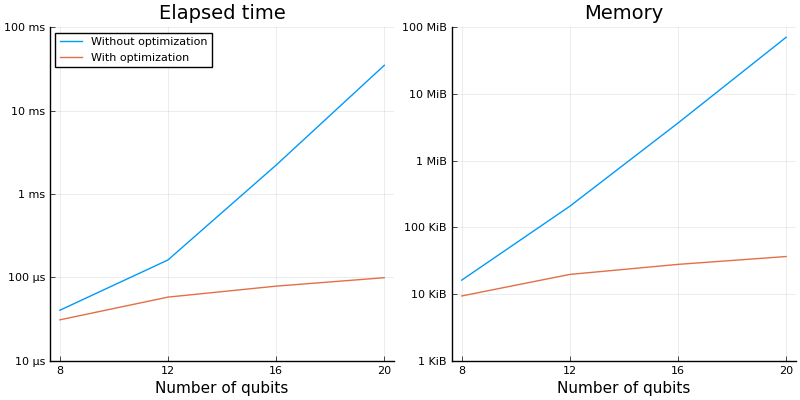

In [19]:
tag = "logdepth"
plot_benchmark(tag)

Though the original paper only considered tensor networks with input product state and projected onto another product state, their theorem on complexity is valid also for mps input that is at the end projected onto another mps. In general, their theorem on complexity is valid for every tensor network with no open legs. Here are the numerical results for the mps case.

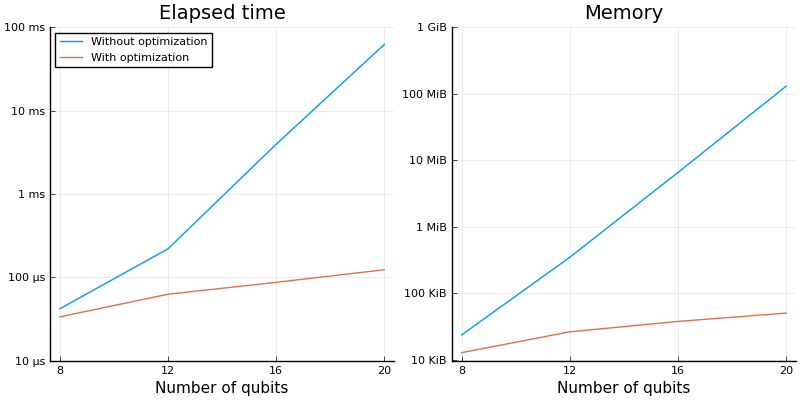

In [20]:
tag = "logdepth_mps"
plot_benchmark(tag)

### Local interactions

"Planar graps $G$ with $n$ vertices are known to have treewidth $\mathrm{tw}(G) = O(\sqrt(|V(G)|))$" (cfr. [1](https://arxiv.org/abs/quant-ph/0511069)). The number of vertices when doing the decomposition of the gates goes with $N*r$, where $r$ is the maximum distance between addressed qubits in a gate. Thus, the complexity scales with $T\exp(\sqrt(r)\sqrt(T))$; i.e., subexponential. 

Below is shown the difference in performance for a circuit with

* N qubits
* 5N two-qubit gates of qubits at most 2 qubits appart

For `N = 6` the circuit would be of the following form:

    1 ——————————————————————————————————————□—————————————————————————————————————————□———
                                            |                                         |   
    2 ————————□—————□———————————————————————□—————————————————————————————————————————————
              |     |                                                                 |   
    3 ——□———————————————————————□———————————□———————————□—————□———————————————————————□———
        |     |     |           |           |           |     |                           
    4 ——□—————□—————□—————□———————————□———————————□—————□—————□—————□———————————□—————□———
                          |     |     |     |     |                 |           |     |   
    5 ————————————————————□—————□—————□—————□—————□—————□—————□—————□—————□———————————□———
                                                        |     |           |     |         
    6 ——————————————————————————————————————————————————□—————□———————————□—————□—————————

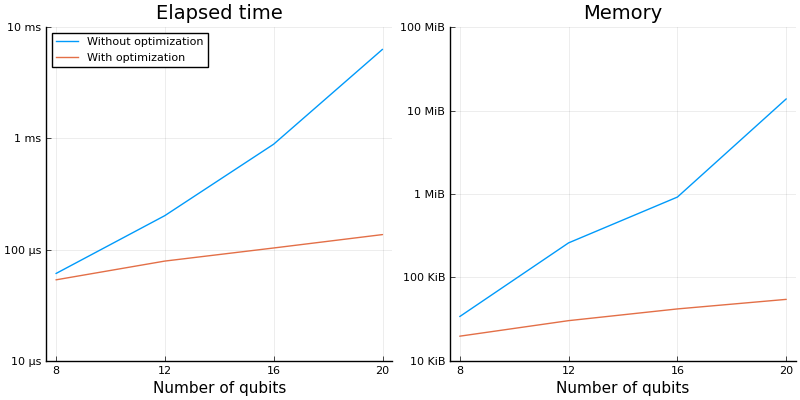

In [21]:
tag = "local"
plot_benchmark(tag)

And for the mps case...

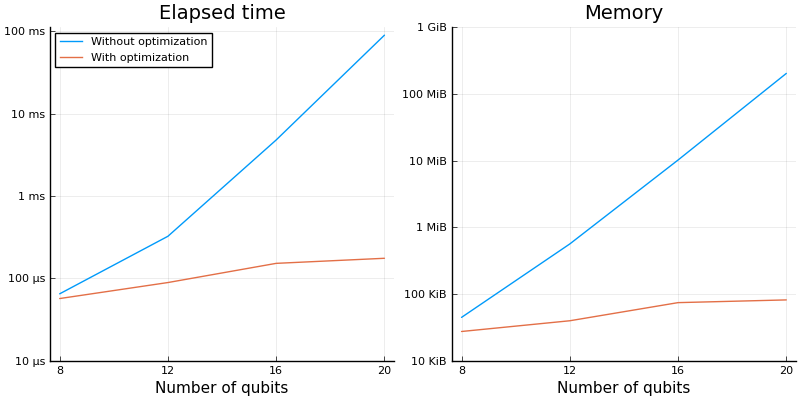

In [22]:
tag = "local_mps"
plot_benchmark(tag)

### General circuit of size N

In the general case there is no change in complexity; however the good contraction order gives better results. Below, for a random circuit of two-qubit gates.

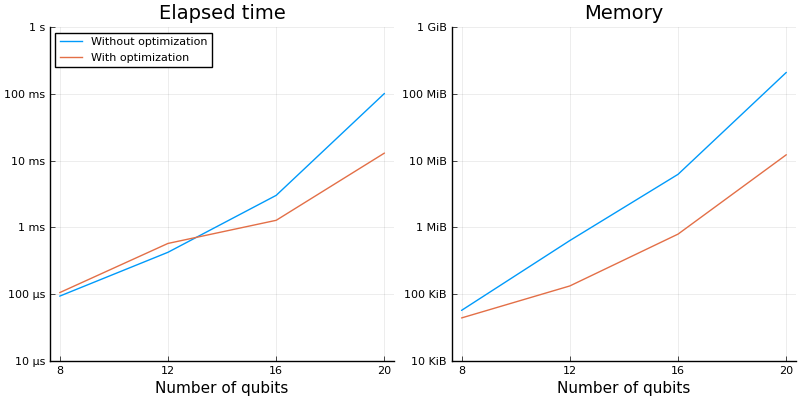

In [23]:
tag = "general"
plot_benchmark(tag)

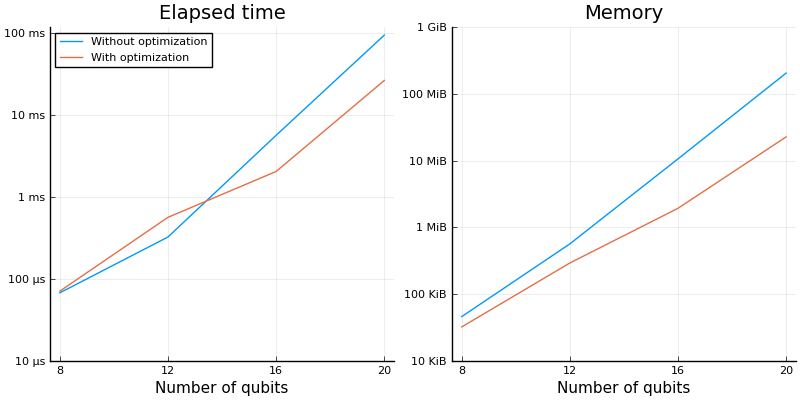

In [24]:
tag = "general_mps"
plot_benchmark(tag)

### Replicate benchmark

In [57]:
using BenchmarkTools

#tag = "logdepth"
tag = "general"
#tag = "local"

mps_type = false

if tag == "logdepth"
    generate_TN(M, N) = log_depth_TN(M, N, 1, mps_type = mps_type)
elseif tag == "local"
    generate_TN(M, N) = rand_local_TN(2, N, 3, 3*N, mps_type = mps_type)
elseif tag == "general"
    generate_TN(M, N) = rand_local_TN(2, N, N, 3*N, mps_type = mps_type)
else
    error("tag not defined")
end


using CSV
using DataFrames
using Statistics: mean

M = 2
Ns = [8, 12, 16, 20]
times = zeros(Float64, length(Ns), 2)
memory = zeros(Float64, length(Ns), 2)
for (i, N) in enumerate(Ns)

    print("N = $N: ")
    T, cgc = generate_TN(M, N)

    bench1 = @benchmark Qaintensor.contract($T)
    print("bench1,...")

    optimize_contraction_order!(T)
    bench2 = @benchmark Qaintensor.contract($T)
    println("bench2.")
    times[i, 1] = mean(bench1.times)
    times[i, 2] = mean(bench2.times)


    memory[i, 1] = bench1.memory
    memory[i, 2] = bench2.memory
end

df = DataFrame(N = Ns, time_notopt = times[:,1], time_opt = times[:,2],
            memory_notopt = memory[:,1], memory_opt = memory[:,2])
if mps_type
    CSV.write("data/benchmark_$(tag)_mps.csv", df)
else
    CSV.write("data/benchmark_$(tag).csv", df)
end

N = 8: bench1,...bench2.
N = 12: bench1,...bench2.
N = 16: bench1,...bench2.
N = 20: bench1,...bench2.


"data/benchmark_general_mps.csv"